# Mobile Network quality prediction based on measurement data #

**Course:** Probabilistic Machine Learning (SoSe 2025)  
**Lecturer:** [Alvaro Dias-Ruelas]  
**Student Name:** Arne Steffensen  
**GitHub Username:** Pinkcamouflage  
**Date:** 14.05.2025  
**Project-ID:** 1SAXXXX

## 1. Introduction ##
Accelerating mobile networks data transfers has been the primary objective for all telecommunicaion companies since their establishment. In this project the answer to the question of network quality depending on the location of the receiver is being answered based on a limited dataset around the airport Leipzig-Halle. In visualizing the data during the exploration phase of the project an application of the HTWK RadioLab is being used. I am a part of the development team for this particular application and have participated partially or completely in the features used here later on.

The local quality of the mobile network can best be described by the three parameters **RSRP**, **NR Scheduled PUSCH Thp in MBit/s** and **NR Avg PUSCH MCS**.
The dataset features the following parameters:

- **Timestamp**: Timestamp when the measurement was made  
- **Latitude**: Latitude coordinate where the measurement was made  
- **Longitude**: Longitude coordinate where the measurement was made  
- **NR PCI**: The Physical Cell Identifier of the particular base station  
- **NR Serving SSB Index**: Index of the Synchronization Signal Block  
- **NR SS-RSRP in dBm**: Reference Signal Received Power  
- **NR Scheduled PUSCH Thp in MBit/s**: Data rate of the uplink  
- **NR Avg Num PUSCH RB**: Average number of Ressource Blocks allocated for uplink  
- **NR Avg PUSCH MCS**: Average Modulation and Coding Scheme used for the uplink
- **NR Distance in meters**: Distance from the base station to the device  
- **NR Direction in degrees**: Azimuth angle from the base station to the device  
- **NR Direction Delta in degrees**: Delta angle between of the movement of the user and the cell  
- **Label**: irrelevant

The dataset includes 12741 measurement points. However, there are only 8798 points with values for one of the target features **RSRP**. The area only partially spans the surroundings of a single cell. Therefore, it is expected that no real generalizations can be made for even regional unseen locations. In the following, steps in cleaning the dataset and exploration are being made.

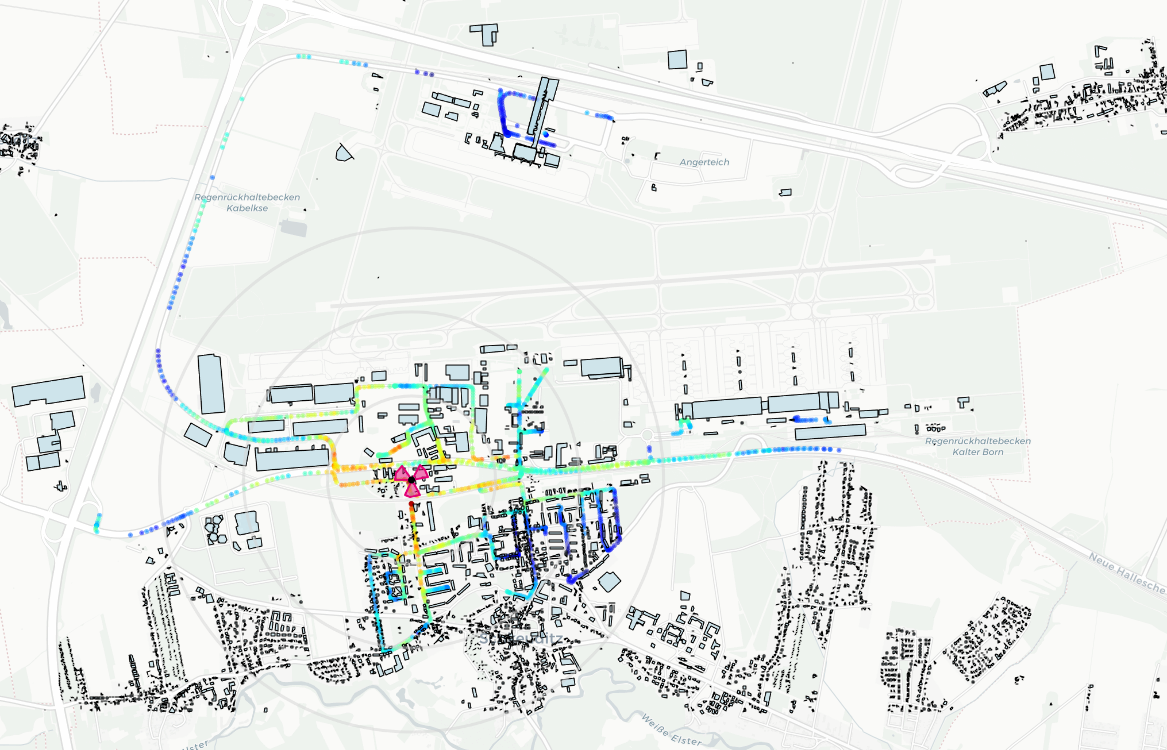

This image shows the **RSRP** on a map in combination with the serving cell. It is clearly visible that the closer you get to the base station, the **RSRP** value increases. Additionally, building blocking seems to have an impact. However, the dataset does not include any properties to describe building shape or height.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

with open('../data/measurement_data_export.csv', 'r') as file:
    df = pd.read_csv(file, sep=',', header=0)

df.describe()

,Latitude,Longitude,NR PCI,NR Serving SSB Index,NR SS-RSRP [dBm],NR Scheduled PUSCH Thp [MBit/s],NR Avg Num PUSCH RB,NR Avg PUSCH MCS,NR Distance [m],NR Direction [Â°],NR Direction Delta [Â°]
count,12741.000000,12741.000000,9882.000000,8800.000000,8798.000000,12735.000000,10892.000000,12741.000000,9814.000000,9814.000000,9814.000000
mean,51.403675,12.228570,305.075187,2.346477,-96.673005,13.346902,120.143775,12.242603,983.256394,37.058133,2.753670
std,0.008000,0.025369,219.499334,1.836374,10.445200,16.689372,84.221354,5.315915,650.927261,98.914357,34.550479
min,51.382744,12.184321,216.000000,0.000000,-122.100000,0.000000,4.000000,0.000000,21.408394,-179.967205,-179.360298
25%,51.398595,12.212584,216.000000,1.000000,-104.000000,0.063418,6.000000,9.000000,555.462562,-41.262990,-17.202280
50%,51.402922,12.220806,217.000000,2.000000,-97.300000,6.478483,162.000000,12.000000,772.895754,61.387887,3.164770
75%,51.405561,12.234831,218.000000,4.000000,-90.000000,22.701567,194.000000,16.000000,1239.087640,113.076877,22.798972
max,51.424994,12.313498,931.000000,6.000000,-58.100000,69.122776,217.000000,30.000000,4560.819024,179.955309,179.329890


This plot shows the kernel density estimation using 1000 evenly distributed gaussian kernels with h = 5 of the **RSRP** feature of the dataset. It clearly shows that the bulk of datapoints lie between -120 and -70 with some nullish outliers at 0 which need to be removed, since there is no way to receive 0 as **RSRP**.
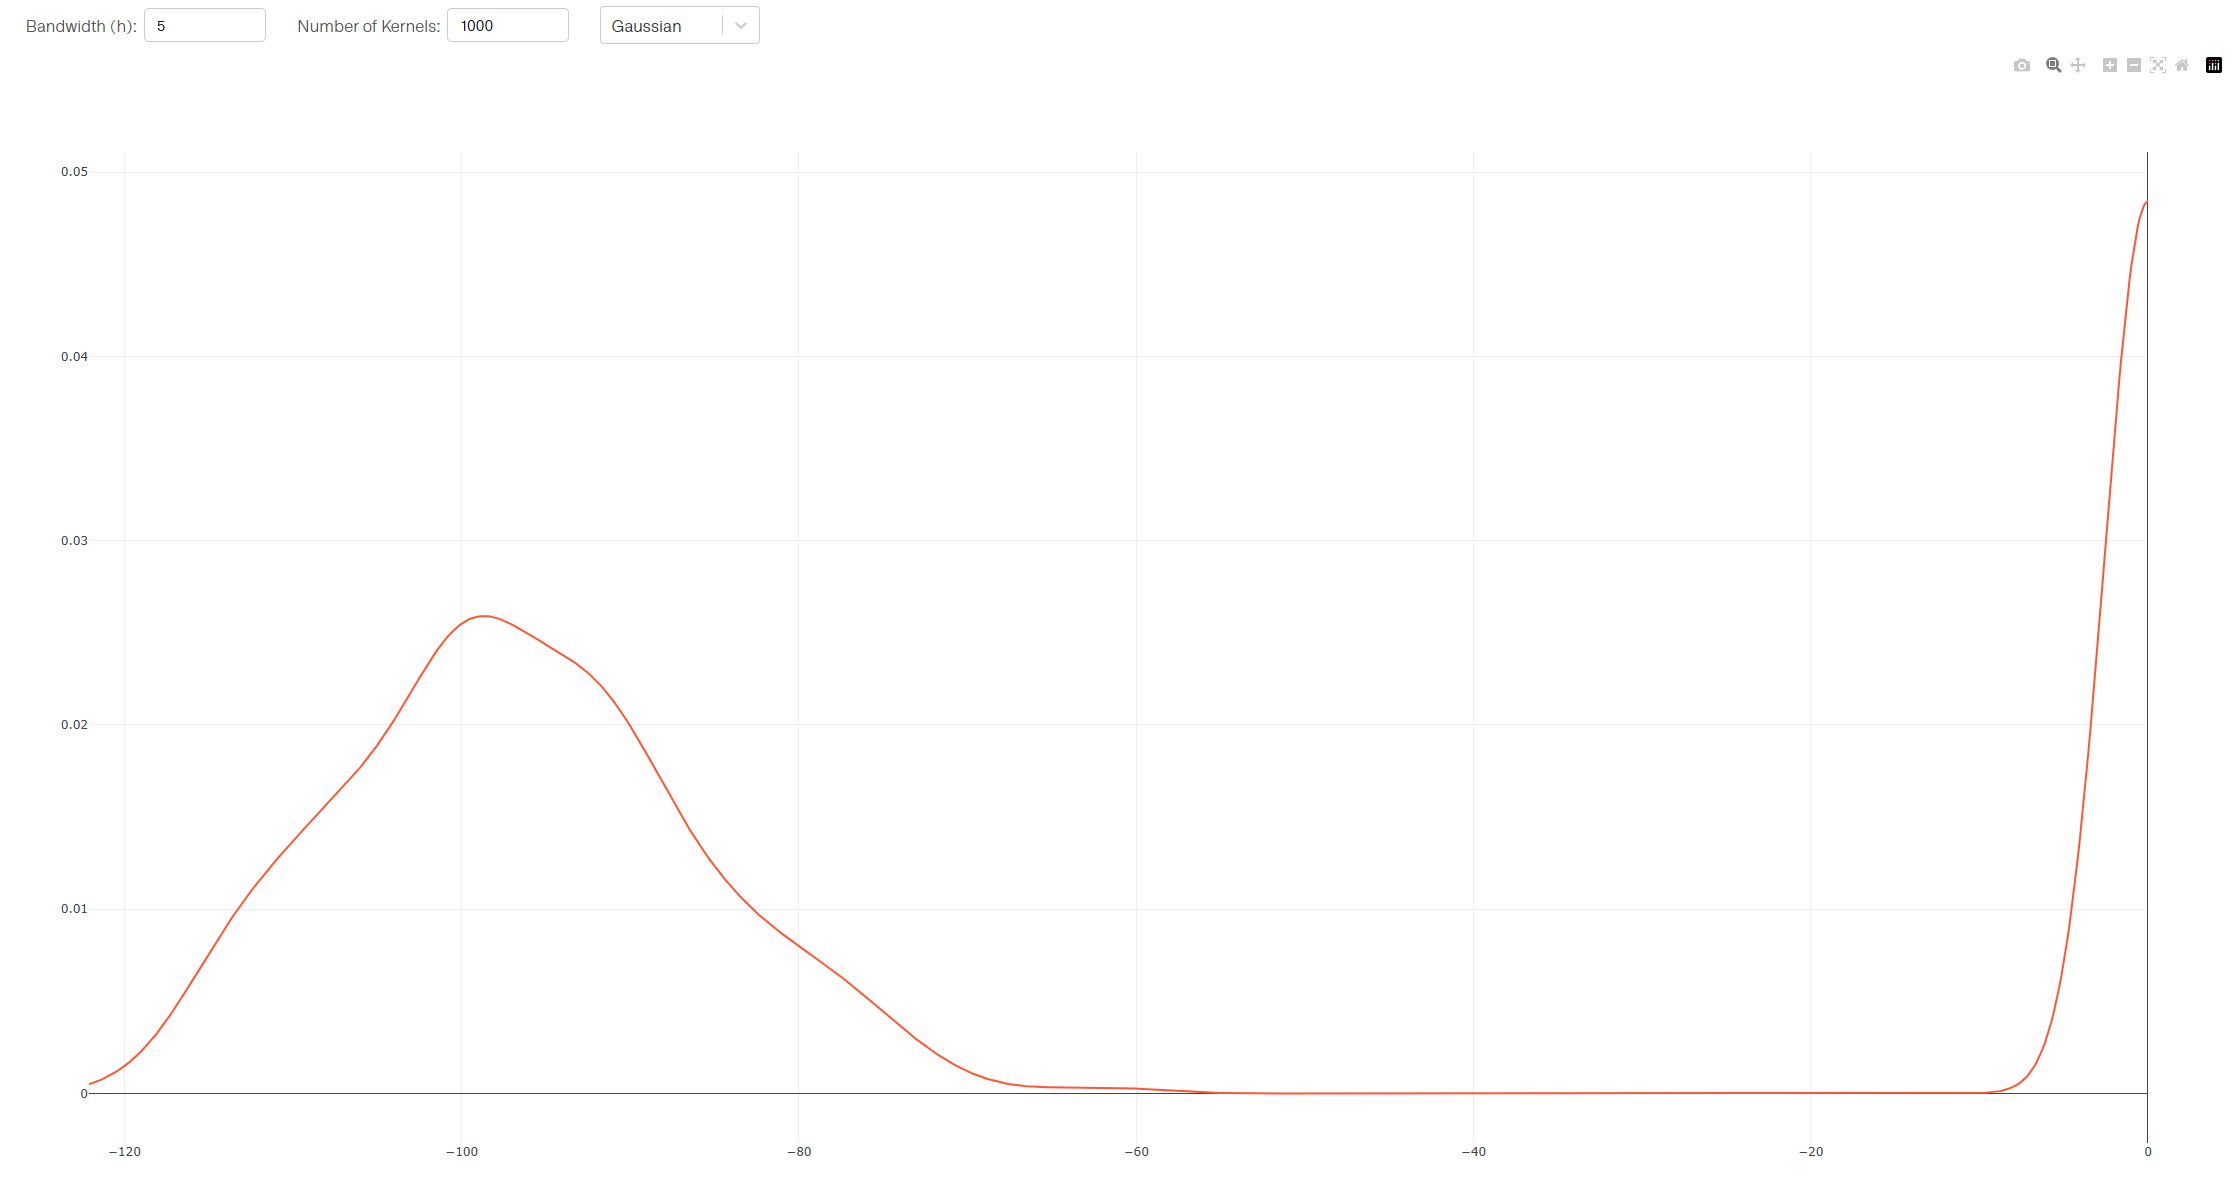

In the following the correlation between the target features is being analyzed before cleaning. The results show a high correlation between **RSRP** and **PUSCH Rate**. However there is only a medium correlation between the two and **PUSCH MCS** (Modulation and Coding Scheme).

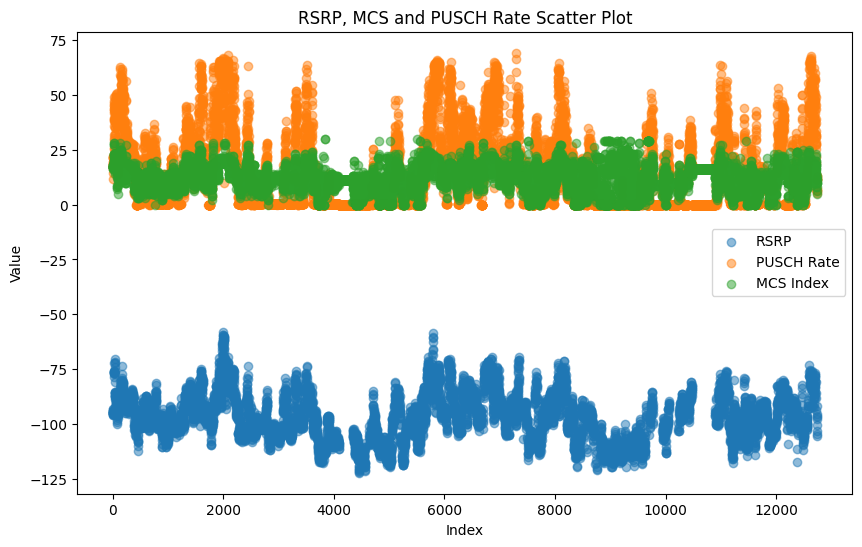

Correlation between RSRP and PUSCH Rate: 0.83
Correlation between RSRP and MCS Index: 0.63
Correlation between PUSCH Rate and MCS Index: 0.58


In [5]:
rsrp = df['NR SS-RSRP [dBm]']
puschRate = df['NR Scheduled PUSCH Thp [MBit/s]']
mcsIndex = df['NR Avg PUSCH MCS']

plt.figure(figsize=(10, 6))
plt.scatter(rsrp.index, rsrp, alpha=0.5, label='RSRP')
plt.scatter(puschRate.index, puschRate, alpha=0.5, label='PUSCH Rate')
plt.scatter(mcsIndex.index, mcsIndex, alpha=0.5, label='MCS Index')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('RSRP, MCS and PUSCH Rate Scatter Plot')
plt.show()

rsrpPuschRateCorrelation = rsrp.corr(puschRate)
rsrpMcsIndexCorrelation = rsrp.corr(mcsIndex)
puschRateMcsIndexCorrelation = puschRate.corr(mcsIndex)

print(f'Correlation between RSRP and PUSCH Rate: {rsrpPuschRateCorrelation:.2f}')
print(f'Correlation between RSRP and MCS Index: {rsrpMcsIndexCorrelation:.2f}')
print(f'Correlation between PUSCH Rate and MCS Index: {puschRateMcsIndexCorrelation:.2f}')

After preprocessing the correlation between **RSRP** and **PUSCH Rate** remain the same, but the correlation between the two and **PUSCH MCS** increased slighly.

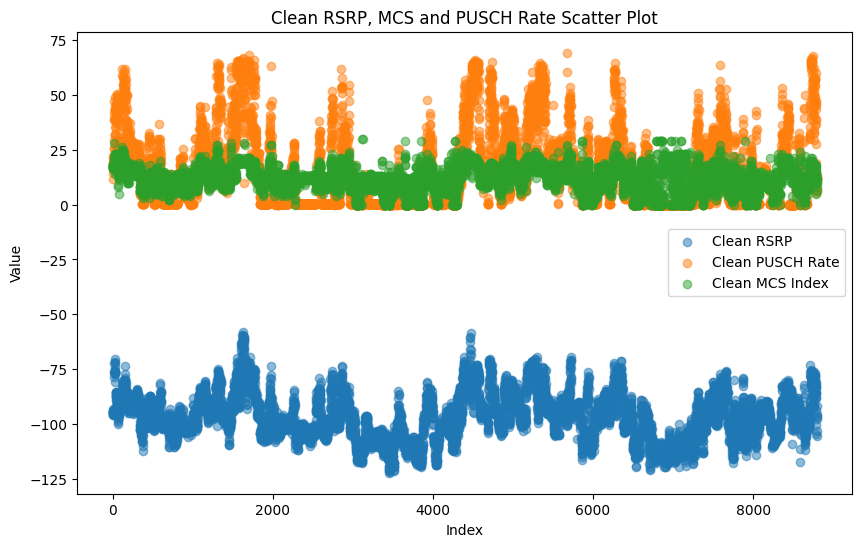

Clean Correlation between RSRP and PUSCH Rate: 0.83
Clean Correlation between RSRP and MCS Index: 0.63
Clean Correlation between PUSCH Rate and MCS Index: 0.67


In [8]:
with open('../data/cleaned_data_RSRP.csv', 'r') as file:
    cleanedRSRPData = pd.read_csv(file,sep=',', header=0)
    
cleanRSRP = cleanedRSRPData['NR SS-RSRP [dBm]']
cleanPuschRate = cleanedRSRPData['NR Scheduled PUSCH Thp [MBit/s]']
cleanMcsIndex = cleanedRSRPData['NR Avg PUSCH MCS']

plt.figure(figsize=(10, 6))
plt.scatter(cleanRSRP.index, cleanRSRP, alpha=0.5, label='Clean RSRP')
plt.scatter(cleanPuschRate.index, cleanPuschRate, alpha=0.5,
            label='Clean PUSCH Rate')
plt.scatter(cleanMcsIndex.index, cleanMcsIndex, alpha=0.5, label='Clean MCS Index')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Clean RSRP, MCS and PUSCH Rate Scatter Plot')
plt.show()

cleanRSRPPuschRateCorrelation = cleanRSRP.corr(cleanPuschRate)
cleanRSRPMcsIndexCorrelation = cleanRSRP.corr(cleanMcsIndex)
cleanPuschRateMcsIndexCorrelation = cleanPuschRate.corr(cleanMcsIndex)
print(f'Clean Correlation between RSRP and PUSCH Rate: {cleanRSRPPuschRateCorrelation:.2f}')
print(f'Clean Correlation between RSRP and MCS Index: {cleanRSRPMcsIndexCorrelation:.2f}')
print(f'Clean Correlation between PUSCH Rate and MCS Index: {cleanPuschRateMcsIndexCorrelation:.2f}')